<h2>OBSERVATIONAL ASTROPHYSICS – FALL 2019 Reduction Exercise: Part 5</h2>

The goal of this part is to produce a color-magnitude diagram for your cluster.  Do do this we need to detect stars, measure their flux, compare it to a known magnitude for that star, derive the magnitude zeropoint for that band, and convert all of your fluxes to magnitudes.  This will be broked into the following steps:

1. read in image with a valid astrometric header (the output image from the end of part 4);
2. Locate stars in this image and measure their flux;
3. Read in an ASCII file with a list of measured magnitudes for stars in that cluster;
4. Cross-match the two lists to find which object corresponds to which;
5. Compare the fluxes and magnitudes to determine the magnitude zeropoint of your image, i.e. what magnitude is a single count;
6. Use this to create magnitudes in each band
7. Produce a color-magnitude diagrame

The first cell below is a routine designed to read in one image

In [1]:
import os, glob, time
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt
from astropy import units as u

#redpath = "/Users/grudnick/Work/Teaching/Classes/Astro_596/Fall_2019/Observing_project/Data/Reduced/20191104/"
redpath = '/home/c055g248/ASTR596/Data/Reduced/20191105/'

A routine to display in image

In [2]:
def display_image(img, minclip=5, maxclip=95, label=None, cmap='Greys_r', 
                  srcs=None, projection=None, calibrated=False):
    """Simple wrapper to display an image.
    
    """
    from astropy.visualization import AsinhStretch as Stretch
    from astropy.visualization import ZScaleInterval as Interval
    from astropy.visualization.mpl_normalize import ImageNormalize

    #from astropy.visualization import simple_norm
    #norm = simple_norm(img, min_percent=minclip, max_percent=maxclip)

    interval = Interval(contrast=0.5)
    vmin, vmax = interval.get_limits(img)
    norm = ImageNormalize(interval=interval, stretch=Stretch(a=0.9))

    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': projection})
    im = ax.imshow(img, origin='lower', norm=norm, cmap=cmap,
                   vmin=vmin, vmax=vmax)
    if projection:
        ax.coords.grid(color='red')
        ax.coords['ra'].set_axislabel('Right Ascension')
        ax.coords['dec'].set_axislabel('Declination')      
    else:
        ax.set_xlabel('Column Number (pixels)')
        ax.set_ylabel('Row Number (pixels)')

    # Mark the locations of stars.
    if srcs:
        from photutils import CircularAperture
        pos = np.transpose((srcs['xcentroid'], srcs['ycentroid']))
        aps = CircularAperture(pos, r=12.)
        aps.plot(color='red', lw=1.5, alpha=0.6, axes=ax)
      
    # Make room for the colorbar
    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.28, 0.05, 0.45])
    c = plt.colorbar(im, cax=cax)
    if label:
        c.set_label(label)
    else:
        if calibrated:
            c.set_label(r'Intensity ($e^{-}/s$)')
        else:
            c.set_label('Intensity (ADU)')

<h3> Find the stars in your image</h3>

In [3]:
#filename should be the name of the combined image file (without path) that has the original header
#wcsfilename should be the name of the image that has the correct WCS header, e.g. one output
#by astrometry.net. 
def read_one_image(filename, wcsfilename, redpath):
    from astropy.table import Table
    from astropy.wcs import WCS

    # This joins the path and the filename
    imgfile = os.path.join('{}'.format(redpath), filename)
    wcsfile = os.path.join('{}'.format(redpath), wcsfilename)

    print('Reading {}'.format(imgfile))
    #this is the image and full header of the file.  
    img, hdr = fits.getdata(imgfile, header=True)
    wcshdr = fits.getheader(wcsfile)

    #this is only the section of the file that contains the WCS, which is the mapping between pixel 
    #and sky coordinate (RA,DEC)
    imgwcs = WCS(wcshdr)#, naxis=2)

    return img, hdr, imgwcs, imgfile

In [4]:
img_king20_V, hdr_king20_V, imgwcs_king20_V, imgfile_king20_V = read_one_image('king20_V_comb.fits','wking20_V_comb.fits',redpath)
img_king20_B, hdr_king20_B, imgwcs_king20_B, imgfile_king20_B = read_one_image('king20_B_comb.fits','wking20_B_comb.fits',redpath)

img_ngc7128_V, hdr_ngc7128_V, imgwcs_ngc7128_V, imgfile_ngc7128_V = read_one_image('ngc7218_V_comb.fits','wngc7128_V_comb.fits',redpath)
img_ngc7128_B, hdr_ngc7128_B, imgwcs_ngc7128_B, imgfile_ngc7128_B = read_one_image('ngc7128_B_comb.fits','wngc7128_B_comb.fits',redpath)

Reading /home/c055g248/ASTR596/Data/Reduced/20191105/king20_V_comb.fits
Reading /home/c055g248/ASTR596/Data/Reduced/20191105/king20_B_comb.fits
Reading /home/c055g248/ASTR596/Data/Reduced/20191105/ngc7218_V_comb.fits
Reading /home/c055g248/ASTR596/Data/Reduced/20191105/ngc7128_B_comb.fits


This is the same routine that we used in part 4.  It measures the background.

In [5]:
def get_sky_background(img, verbose=True):
    from astropy.stats import SigmaClip
    from photutils import Background2D, MedianBackground
    sigma_clip = SigmaClip(sigma=4.)
    bkg = Background2D(img, (100, 100), filter_size=(10, 10), sigma_clip=sigma_clip, 
                       bkg_estimator=MedianBackground())
    if verbose:
        print('Sky background median = {:.3f}, rms = {:.3f} electrons.'.format(bkg.background_median, bkg.background_rms_median))
    return bkg

This gets the background and subtracts it from the image to get a background subtracted image.  As in part 4 we check that the background looks correct.

In [6]:
#***********
bkg_V = get_sky_background(img_king20_V, verbose=True)
img_king20_V_nosky = img_king20_V - bkg_V.background

bkg_B = get_sky_background(img_king20_B, verbose=True)
img_king20_B_nosky = img_king20_B - bkg_B.background

nbkg_V = get_sky_background(img_ngc7128_V, verbose=True)
img_ngc7128_V_nosky = img_ngc7128_V - bkg_V.background

nbkg_B = get_sky_background(img_ngc7128_B, verbose=True)
img_ngc7128_B_nosky = img_ngc7128_B - bkg_B.background

Sky background median = 2.616, rms = 0.063 electrons.
Sky background median = 2.280, rms = 0.058 electrons.
Sky background median = 2.691, rms = 0.062 electrons.
Sky background median = 2.367, rms = 0.059 electrons.


In [7]:
def qa_background(img,img_nosky,bkg):
    med, sig = bkg.background_median, bkg.background_rms_median
    vrange = (-3*sig, med+5*sig)
    fig, ax = plt.subplots(figsize=(7, 5))
    _ = ax.hist(img.flatten(), bins=100, range=vrange, label='Image w/ Background')
    #_ = ax.hist(bkg.background.flatten(), bins=50, range=(-sig, med+5*sig), label='Background')
    _ = ax.hist(img_nosky.flatten(), bins=100, range=vrange, label='Image w/o Background')
    ax.axvline(x=bkg.background_median, lw=2, ls='-', color='k')
    ax.set_xlabel('Intensity (e-/s)')
    ax.set_ylabel('Number')
    ax.legend(fontsize=12, frameon=False)

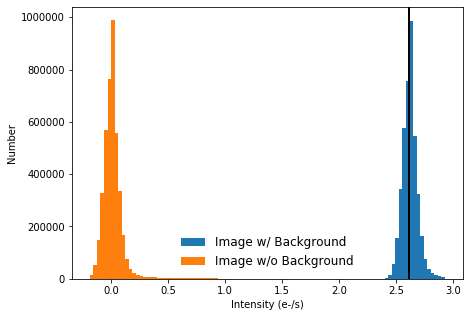

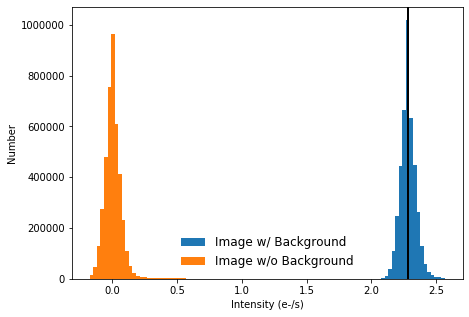

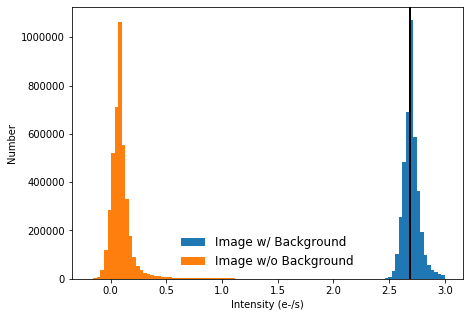

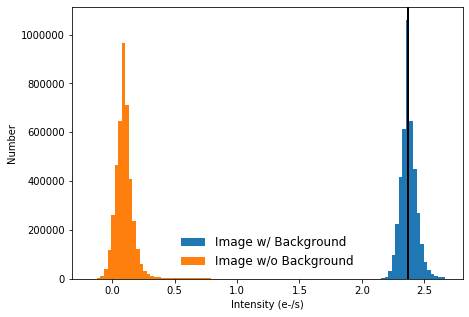

In [8]:
#***********
qa_background(img_king20_V, img_king20_V_nosky,bkg_V)
qa_background(img_king20_B, img_king20_B_nosky,bkg_B)

qa_background(img_ngc7128_V, img_ngc7128_V_nosky,nbkg_V)
qa_background(img_ngc7128_B, img_ngc7128_B_nosky,nbkg_B)

This routine detects stars in the image.  It requires a zero background image.  There are many ways to measure object flux.  We are using the DAOStarfinder algorithm described (https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html)

This code requires as input the FWHM of stars in the image in pixel units.  You can determine this using the *imexam* task.

You can use this by going to your image directory and typing *ipython* at the command line.  Once the interactive python environment loads you type the following set of commands:

*import imexam*

*viewer=imexam.connect()*

*viewer.load_fits('<filename>')*
    
*viewer.scale()*
    
You can then hit the "a" key and "r" key on bright isolated and unsaturated stars to find the FWHM.

If imexam doesn't work on your computer then just use the mean FWHM from all the individual observations for that band/target

This will need to be run once for each band

In [9]:
#this code outputs a file with all the detected stars.
#fwhm is for stars in the image in units of pixels
#nsigma is the detection threshold for each star
def find_stars(image, imgfile, fwhm=3.0, nsigma=3, sigma=None, 
               verbose=True, overwrite=False):
    from astropy.table import Table
    
    #this makes a file 
    starsfile = os.path.join(redpath, 'stars-{}'.format(os.path.basename(imgfile)))
    if not os.path.isfile(starsfile) or overwrite:
        from photutils import DAOStarFinder
        if sigma is None:
            sigma = np.std(image)

        daofind = DAOStarFinder(fwhm=fwhm, threshold=nsigma * sigma)
        srcs = daofind(image)
        # reverse-sort by flux 
        srcs.sort('flux')
        srcs.reverse()
        if verbose:
            print('Found {} sources'.format(len(srcs)))

        print('Writing {} stars to {}'.format(len(srcs), starsfile))
        srcs.write(starsfile, overwrite=True)
    else:
        srcs = Table.read(starsfile)
        print('Read {} stars from {}'.format(len(srcs), starsfile))
    return srcs

In [10]:
#***********
srcs_king20_V = find_stars(img_king20_V_nosky, imgfile_king20_V, sigma=bkg_V.background_rms_median, nsigma=5, 
                  verbose=True, overwrite=False)
srcs_king20_V

Read 943 stars from /home/c055g248/ASTR596/Data/Reduced/20191105/stars-king20_V_comb.fits


<Table length=943>
  id      xcentroid      ...        flux                 mag          
int64      float64       ...      float64              float64        
----- ------------------ ... ------------------ ----------------------
  538  1149.181936588282 ... 1459.9076057403117     -7.910813427839745
  409 236.28433252187858 ...   1378.86168735776     -7.848801761469516
  405 236.21109684504867 ... 1342.3336695824012     -7.819651209191915
  279  1973.936185472414 ...  1287.968523475649     -7.774763123693267
  407  236.2802569055588 ... 1279.0624302367457      -7.76722935659465
  406 233.59696145262288 ... 1256.3025667402887    -7.7477356176927294
  602 1498.0541718431311 ...  994.2137317200971     -7.493699392906368
  523 1450.4930823802674 ...  981.5201278353405     -7.479748025041772
  106 1451.5531248425445 ...  835.3032128851964     -7.304610379665814
  718  385.8730476585883 ...  756.1314068162898    -7.1964931934353125
  ...                ... ...                ...                    ...
  365  794.5187401711046 ... 1.0100995728881264  -0.010910468675304973
  221 1693.6357090030813 ... 1.0099911999303712  -0.010793974460740378
  861 1753.5616166369196 ... 1.0088726381088065  -0.009590858957533957
  427 232.92632368436813 ...  1.008746041867862  -0.009454609106435575
  886 1685.5010643728883 ...  1.008387588642775   -0.00906872921984866
  708  374.6491356957722 ... 1.0068194767551077  -0.007379020780037492
  880  290.7966094131956 ... 1.0063309361218602  -0.006852059396494627
  264  1075.779607127675 ... 1.0044183831956648 -0.0047866317852471455
  830 1867.5950081835354 ... 1.0014119568696613 -0.0015319314367184982
  107  788.9742309078315 ...  1.000157926063631 -0.0001714525069057534

In [11]:
srcs_king20_B = find_stars(img_king20_B_nosky, imgfile_king20_B, sigma=bkg_B.background_rms_median, nsigma=5, 
                  verbose=True, overwrite=False)
srcs_king20_B

Read 437 stars from /home/c055g248/ASTR596/Data/Reduced/20191105/stars-king20_B_comb.fits


<Table length=437>
  id      xcentroid      ...        flux                 mag          
int64      float64       ...      float64              float64        
----- ------------------ ... ------------------ ----------------------
  175 50.472877634742744 ...  1176.901343510656    -7.6768501465633285
  239  963.2552958718326 ...  665.2826177515852     -7.057515441287649
  124 1788.3679660184775 ...  518.1855864880371       -6.7862133219151
  229 1264.5317982502352 ... 438.89216616156324     -6.605894572850825
  433  752.4651075811839 ...  354.1212819938809     -6.372880069470597
  319  978.6485626790394 ... 329.97434576366624     -6.296200441161613
  337 199.81117930310776 ... 242.48376979389502      -5.96170668801744
   56   450.241910311937 ... 232.27518015343625     -5.915007013972314
   45 1266.2197511033812 ... 173.25932041927044    -5.5967415165470005
  273 1312.1509373298138 ... 144.32986203302806     -5.398390491185352
  ...                ... ...                ...                    ...
  103 1528.0738688922677 ... 1.0173391324442804   -0.01866437541853293
  159 1097.4490557537151 ... 1.0114136443181607  -0.012322020295192072
  351   852.275981074103 ... 1.0099342680715497  -0.010732771231886406
  263 1875.0223559613355 ...  1.009851466398386  -0.010643751121599897
  431  867.6371943596288 ... 1.0089801646914573  -0.009706571564228049
  352  349.8834587194304 ... 1.0087475919800448   -0.00945627752599349
  167  1149.539683604122 ... 1.0049552715803893 -0.0053668316596665626
   21  984.7185645711429 ...  1.002335143892217  -0.002532394663533219
   92  983.0871184856999 ... 1.0019398363756595 -0.0021041104285551664
   38 1821.3713981666701 ... 1.0014868884727042 -0.0016131696425633103

In [12]:
srcs_ngc7128_V = find_stars(img_ngc7128_V_nosky, imgfile_ngc7128_V, sigma=bkg_V.background_rms_median, nsigma=5, 
                  verbose=True, overwrite=False)
srcs_ngc7128_V

Read 1431 stars from /home/c055g248/ASTR596/Data/Reduced/20191105/stars-ngc7218_V_comb.fits


<Table length=1431>
  id      xcentroid      ...        flux                 mag          
int64      float64       ...      float64              float64        
----- ------------------ ... ------------------ ----------------------
  717 1054.7247904939325 ... 1841.2548999024966      -8.16278478896519
  829  984.6026359341715 ... 1740.8311691186425     -8.101891635036953
 1422  808.6090090541918 ... 1686.8116980690259     -8.067666510482999
  439 1832.4794989082388 ... 1616.2263936332556     -8.021255486732441
  442 1832.7053610785133 ... 1552.3369843521057     -7.977465011632804
  320 1657.3218770996118 ... 1539.7843590009427     -7.968649759471936
  815  854.6229103031174 ... 1191.0351927125641     -7.689811485518576
  707 123.06291959125086 ... 1146.0186232798465    -7.6479791878872305
 1301  965.2307288218766 ... 1007.1938732576621    -7.5077826882556655
  818  857.7489447420037 ...  994.8794013185596     -7.494426097552253
  ...                ... ...                ...                    ...
 1302 1856.9119095369747 ... 1.0068870993750363  -0.007451941361034663
 1037  482.6605561023193 ... 1.0058175964986709  -0.006298073030886054
  225 1013.8526970807089 ... 1.0055560313301963  -0.006015688126372932
  976 1805.3064636461304 ...  1.005354036524352  -0.005797564921241415
  167  256.2412431060364 ... 1.0036067044666401  -0.003908884752955389
 1137    962.96389138537 ... 1.0035105311205972 -0.0038048361383950886
 1285  1160.845223084608 ... 1.0027279157591447 -0.0029577644687727735
  123  390.0491286453956 ... 1.0022220981985086 -0.0024099358980720622
  887 1278.4998212856242 ... 1.0011202033486957 -0.0012155646196334701
  456  347.5943964651558 ... 1.0010652596585106  -0.001155975380999844

In [13]:
srcs_ngc7128_B = find_stars(img_ngc7128_B_nosky, imgfile_ngc7128_B, sigma=bkg_B.background_rms_median, nsigma=5, 
                  verbose=True, overwrite=False)
srcs_ngc7128_B

Read 801 stars from /home/c055g248/ASTR596/Data/Reduced/20191105/stars-ngc7128_B_comb.fits


<Table length=801>
  id      xcentroid      ...        flux                 mag          
int64      float64       ...      float64              float64        
----- ------------------ ... ------------------ ----------------------
  484 1085.4876444056183 ... 1783.6887339566917      -8.12829767313929
   56  215.8661092223832 ...   1640.80604967568     -8.037643121533273
  181  1886.346762470297 ... 1294.9734987369916    -7.7806522019890165
  493  1213.825284165738 ... 1182.2325362795405     -7.681757268542626
  422  352.1633115717417 ...  936.0630569295996     -7.428262763816843
  735 1194.7853178354158 ...  752.9611618887086     -7.191931439132486
  187 1903.3211672139407 ...  731.9628778347933     -7.161222639939973
  430 1309.0419451180971 ...  668.4459311438736    -7.0626657101635795
  794 1038.2903765701835 ...  644.8555868249974     -7.023656166947799
  340 1142.9293410982953 ...  543.6238291121343     -6.838246213165721
  ...                ... ...                ...                    ...
  583  893.7136916453694 ... 1.0158597674568393  -0.017084401702788753
  329   1952.18235947973 ...  1.015481754224616  -0.016680311447694322
  530  800.3043321221844 ... 1.0147244592448441  -0.015870322186604193
  718  731.9483524010244 ...  1.012569295041437  -0.013561884468224365
  285 1569.1050035898677 ...  1.008984238648795  -0.009710955430435864
   85  938.5601834967074 ... 1.0080339785924386  -0.008687928652952814
  542 1433.8016758610993 ... 1.0068574160129615  -0.007419933029650443
  303   706.952035783383 ... 1.0053487676702242  -0.005791874785760118
  537  659.0386236338364 ... 1.0041332146897868  -0.004478332238753176
  773 291.90682638223086 ... 1.0019869036065714 -0.0021551128885239014

<h3> Use stars from Pan-STARRS</h3>

We will be using the large survey called Pan-STARRS (https://panstarrs.stsci.edu/).  Pan-STARRS uses SDSS filters (*griz*), which are different from the "Johnson" *BVR* filters that we are using.  But there are transformation between these filters such that if we know the Pan-STARRS magnitudes of a given object, we can determine its B-V color.

This routine sends a request to a catalog server at a remote location and pulls back all the photometry

In [14]:
def get_panstarrs_catalog(imgwcs, radius=0.2, rfaint=17, region=False):
    from astroquery.mast import Catalogs
    ra0, dec0 = imgwcs.wcs.crval
    print('Querying Pan-STARRS catalog with radius={:.3f} deg and central coordinates RA,Dec={:.5f},{:.5f}'.format(
        radius, ra0, dec0))
    if region:
        allcat = Catalogs.query_region('{} {}'.format(ra0, dec0), radius=radius,
                                       catalog='PANSTARRS', data_release='dr2', 
                                       table='mean')#, rMeanPSFMag=[12, 22])
    else:
        allcat = Catalogs.query_criteria(coordinates='{} {}'.format(ra0, dec0), radius=radius,
                                         catalog='PANSTARRS', data_release='dr2', 
                                         table='mean',
                                         columns=['objID', 'raMean', 'decMean',
                                                  'gMeanPSFMag', 'rMeanPSFMag', 'iMeanPSFMag', 'zMeanPSFMag'],
                                         gMeanPSFMag=[('lte', 18), ('gte', 12)],
                                         rMeanPSFMag=[('lte', 18), ('gte', 12)],
                                         iMeanPSFMag=[('lte', 18), ('gte', 12)],
                                         zMeanPSFMag=[('lte', 18), ('gte', 12)],
                                         sort_by=[("asc", "rMeanPSFMag")])
    

    #we limit ourselves to bright objects so that we know that they will have high Signal-to-Noise
    rmag = allcat['rMeanPSFMag']
    good = np.isfinite(rmag) * rmag < rfaint
    cat = allcat[good]
    print('Keeping {}/{} Pan-STARRS sources with rmag< {}.'.format(len(cat), len(allcat),rfaint))
    
    #make B and V-band magnitudes using the transformations published in Tonry et al. (2012)
    #https://ui.adsabs.harvard.edu/abs/2012ApJ...750...99T/abstract
    cat['B'] = 0.213 + 0.587 * (cat['gMeanPSFMag'] - cat['rMeanPSFMag']) + cat['gMeanPSFMag'] 
    cat['V'] = 0.006 + 0.474 *  (cat['gMeanPSFMag'] - cat['rMeanPSFMag']) + cat['rMeanPSFMag'] 
    
    return cat

In [15]:
%time refcat_king20_V = get_panstarrs_catalog(imgwcs_king20_V, radius=0.2)
refcat_king20_V

Querying Pan-STARRS catalog with radius=0.200 deg and central coordinates RA,Dec=353.29710,58.50003


Keeping 614/623 Pan-STARRS sources with rmag< 17.
CPU times: user 385 ms, sys: 64.6 ms, total: 449 ms
Wall time: 9.13 s


<Table masked=True length=614>
      objID           raMean    ...         B                  V         
      int64          float64    ...      float64            float64      
------------------ ------------ ... ------------------ ------------------
177973533643142604 353.36438085 ... 13.106981146812439 12.278481775283813
178253534222408649 353.42222936 ... 13.765923689842225 12.689336183547974
178063533638825273  353.3639764 ...  13.02220694923401 12.524714305877685
178193533621090461 353.36215886 ... 13.630024438858031 12.808648387908935
178243534353808280 353.43544285 ... 14.003855922698975 13.031112228393555
178283534833775064 353.48342907 ...   13.9078879737854 13.228976211547852
178203532822397719 353.28226479 ... 13.870125274658204 13.245750274658203
178343535329972488 353.53306465 ... 14.700575333595276 13.512020818710328
178153533314536621 353.33152159 ...  15.50825869178772 13.796037685394287
177993533510122174 353.35102874 ... 15.678913128852844 13.861735921859742
               ...          ... ...                ...                ...
178203534202427988 353.42031698 ... 18.822567741394042  17.45181394958496
178213531531431198 353.15311891 ... 18.720883489608763 17.421583683013917
178303533587926326 353.35876197 ...  18.75672840118408 17.440846786499023
178103532385686076 353.23854466 ... 18.719216722488405 17.436725872039794
178303530050130860 353.00500804 ...  18.55760074234009   17.3936450881958
178283536222115729   353.622211 ... 17.761384883880616  17.15927039337158
178053535274722220 353.52743711 ...  18.70315467262268 17.444482524871827
178043533328551756 353.33284466 ...  18.74243766593933 17.456495014190672
178183532549873352 353.25495598 ...   18.7033556060791 17.447908111572264
178123531943045190 353.19428958 ... 18.778003078460692 17.472026817321776

In [16]:
%time refcat_king20_B = get_panstarrs_catalog(imgwcs_king20_B, radius=0.2)
refcat_king20_B

Querying Pan-STARRS catalog with radius=0.200 deg and central coordinates RA,Dec=353.33816,58.52522
Keeping 616/624 Pan-STARRS sources with rmag< 17.
CPU times: user 26.7 ms, sys: 3.91 ms, total: 30.6 ms
Wall time: 3.15 s


<Table masked=True length=616>
      objID           raMean    ...         B                  V         
      int64          float64    ...      float64            float64      
------------------ ------------ ... ------------------ ------------------
178253534222408649 353.42222936 ... 13.765923689842225 12.689336183547974
178063533638825273  353.3639764 ...  13.02220694923401 12.524714305877685
178193533621090461 353.36215886 ... 13.630024438858031 12.808648387908935
178243534353808280 353.43544285 ... 14.003855922698975 13.031112228393555
178383536000947136 353.60019313 ... 14.204368185997009  13.24809697151184
178283534833775064 353.48342907 ...   13.9078879737854 13.228976211547852
178203532822397719 353.28226479 ... 13.870125274658204 13.245750274658203
178343535329972488 353.53306465 ... 14.700575333595276 13.512020818710328
178153533314536621 353.33152159 ...  15.50825869178772 13.796037685394287
177993533510122174 353.35102874 ... 15.678913128852844 13.861735921859742
               ...          ... ...                ...                ...
178213531531431198 353.15311891 ... 18.720883489608763 17.421583683013917
178303533587926326 353.35876197 ...  18.75672840118408 17.440846786499023
178423535470035626 353.54696203 ... 18.455244928359985 17.356620876312256
178103532385686076 353.23854466 ... 18.719216722488405 17.436725872039794
178303530050130860 353.00500804 ...  18.55760074234009   17.3936450881958
178283536222115729   353.622211 ... 17.761384883880616  17.15927039337158
178053535274722220 353.52743711 ...  18.70315467262268 17.444482524871827
178043533328551756 353.33284466 ...  18.74243766593933 17.456495014190672
178183532549873352 353.25495598 ...   18.7033556060791 17.447908111572264
178123531943045190 353.19428958 ... 18.778003078460692 17.472026817321776

In [17]:
%time refcat_ngc7128_V = get_panstarrs_catalog(imgwcs_ngc7128_V, radius=0.2)
refcat_ngc7128_V

Querying Pan-STARRS catalog with radius=0.200 deg and central coordinates RA,Dec=326.10804,53.73698
Keeping 893/923 Pan-STARRS sources with rmag< 17.
CPU times: user 27.8 ms, sys: 0 ns, total: 27.8 ms
Wall time: 11.8 s


<Table masked=True length=893>
      objID           raMean    ...         B                  V         
      int64          float64    ...      float64            float64      
------------------ ------------ ... ------------------ ------------------
172473260768521639 326.07689699 ... 12.996903435707093  12.49050637626648
172353260800752122 326.08018881 ... 13.394347136497498  12.65199419593811
172503258801023374 325.88018571 ... 13.518980298042298 12.710960340499877
172493261417666169 326.14181906 ... 13.128206895828248 12.630714252471924
172283259963169350 325.99613641 ... 12.740485356330872 12.525360036849976
172553259686507433 325.96868718 ... 13.459410614013672 12.773820274353028
172643260773104920 326.07735979 ... 13.424496117591858 12.763392126083374
172473259798384953 325.97983039 ... 13.340492380142212 12.781784397125245
172263261613075141 326.16130382 ... 13.536758253097535 12.846716236114501
172633258688450529 325.86897433 ... 13.562148631095885  12.90549631690979
               ...          ... ...                ...                ...
172573263859626362 326.38594763 ...  18.53606314086914 17.373886459350587
172253262098507265 326.20983042 ... 18.683132452011108  17.41900450515747
172553263777748239 326.37777166 ...   18.7285239238739  17.43957527542114
172553262697941835 326.26978045 ... 18.772572204589842  17.45357420349121
172283261049570474 326.10494312 ...   18.7692272567749 17.453345642089843
172523263433159004 326.34331238 ...   18.7647651386261 17.460569972991944
172273261246300320 326.12461533 ... 18.798280002593994 17.471491035461426
172523260536869365 326.05368032 ... 18.661042865753174 17.431974266052247
172453257754659558 325.77545628 ...  18.75739816093445 17.462997959136963
172493259703374524  325.9703144 ... 18.561794416427613 17.407521213531496

In [18]:
%time refcat_ngc7128_B = get_panstarrs_catalog(imgwcs_ngc7128_B, radius=0.2)
refcat_ngc7128_B

Querying Pan-STARRS catalog with radius=0.200 deg and central coordinates RA,Dec=325.99167,53.70174
Keeping 950/982 Pan-STARRS sources with rmag< 17.
CPU times: user 41.6 ms, sys: 381 µs, total: 42 ms
Wall time: 1min 8s


<Table masked=True length=950>
      objID           raMean    ...         B                  V         
      int64          float64    ...      float64            float64      
------------------ ------------ ... ------------------ ------------------
172473260768521639 326.07689699 ... 12.996903435707093  12.49050637626648
172353260800752122 326.08018881 ... 13.394347136497498  12.65199419593811
172503258801023374 325.88018571 ... 13.518980298042298 12.710960340499877
172493261417666169 326.14181906 ... 13.128206895828248 12.630714252471924
172283259963169350 325.99613641 ... 12.740485356330872 12.525360036849976
172553259686507433 325.96868718 ... 13.459410614013672 12.773820274353028
172643260773104920 326.07735979 ... 13.424496117591858 12.763392126083374
172473259798384953 325.97983039 ... 13.340492380142212 12.781784397125245
172263261613075141 326.16130382 ... 13.536758253097535 12.846716236114501
172633258688450529 325.86897433 ... 13.562148631095885  12.90549631690979
               ...          ... ...                ...                ...
172483260826960724 326.08266776 ... 18.354912998199463 17.316835578918457
172363262159768774  326.2159726 ... 18.674889432907104  17.41387787246704
172223259688794182 325.96884782 ... 18.654996284484863 17.409899948120117
172243259597689236 325.95973675 ... 18.538883678436278 17.383495964050294
172553262697941835 326.26978045 ... 18.772572204589842  17.45357420349121
172283261049570474 326.10494312 ...   18.7692272567749 17.453345642089843
172273261246300320 326.12461533 ... 18.798280002593994 17.471491035461426
172523260536869365 326.05368032 ... 18.661042865753174 17.431974266052247
172453257754659558 325.77545628 ...  18.75739816093445 17.462997959136963
172493259703374524  325.9703144 ... 18.561794416427613 17.407521213531496

We need to match the Pan-STARRS catalog against ours.  First we need to compute the nearest Pan-STARRS star to each of ours and look at the distribution of distances to find the optimal match.

In [19]:
def sep_check(imgwcs,srcs,refcat):
    import astropy.units as u
    from astropy.coordinates import SkyCoord
    
    #this makes an instance of a SkyCoord class containing the RAs and Decs from Pan-STARRS objects
    refcoord = SkyCoord(ra=refcat['raMean']*u.deg, dec=refcat['decMean']*u.deg)
    #This uses the WCS to convert the x and y positions of stars in our image to RA-DEC
    radec_stars = imgwcs.all_pix2world(srcs['xcentroid']+1, srcs['ycentroid']+1, 1)
    #this does the same from our targets 
    coord = SkyCoord(ra=radec_stars[0]*u.deg, dec=radec_stars[1]*u.deg)

    #this calculates the separations.  The "_" are values that are thrown away
    _, sep2d, _ = coord.match_to_catalog_sky(refcoord)

    #plot the histograms
    _ = plt.hist(sep2d.arcsec, bins=100, range=(-0.5, 3))
    return refcoord, coord

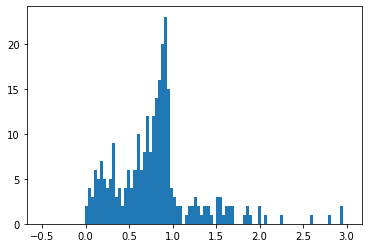

In [20]:
refcoord_king20_V, coord_king20_V = sep_check(imgwcs_king20_V,srcs_king20_V,refcat_king20_V)

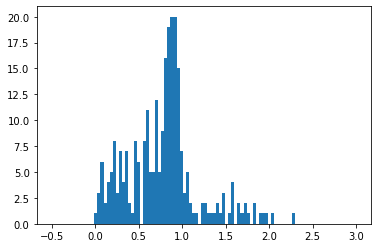

In [21]:
refcoord_king20_B, coord_king20_B = sep_check(imgwcs_king20_B,srcs_king20_B,refcat_king20_B)

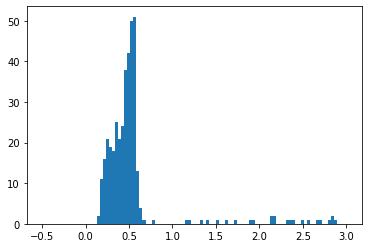

In [22]:
refcoord_ngc7128_V, coord_ngc7128_V = sep_check(imgwcs_ngc7128_V,srcs_ngc7128_V,refcat_ngc7128_V)

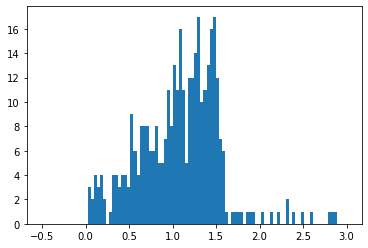

In [23]:
refcoord_ngc7128_B, coord_ngc7128_B = sep_check(imgwcs_ngc7128_B,srcs_ngc7128_B,refcat_ngc7128_B)

It looks like the optimal match is less than 1.0 arcsec.  The following routine matches to within this tolerance

In [24]:
#take two lists of coordinates 
def match_src_ref(refcoord, coord, srcs, img, radasec = 1.0):
    rad = radasec * u.arcsec

    #find the indices of the reference and source list that correspond to matching objects such that
    #the first index in each list corresponds to the first matching object
    indx_ref, indx, d2d, _ = coord.search_around_sky(refcoord, rad)
    nmatch = len(indx_ref)
    print('Found {}/{} stars within {}'.format(nmatch, len(srcs), rad))
    display_image(img, srcs=srcs[indx], calibrated=True)
    return indx, indx_ref

Found 225/943 stars within 1.0 arcsec
Found 219/437 stars within 1.0 arcsec
Found 362/1431 stars within 1.5 arcsec
Found 319/801 stars within 1.5 arcsec


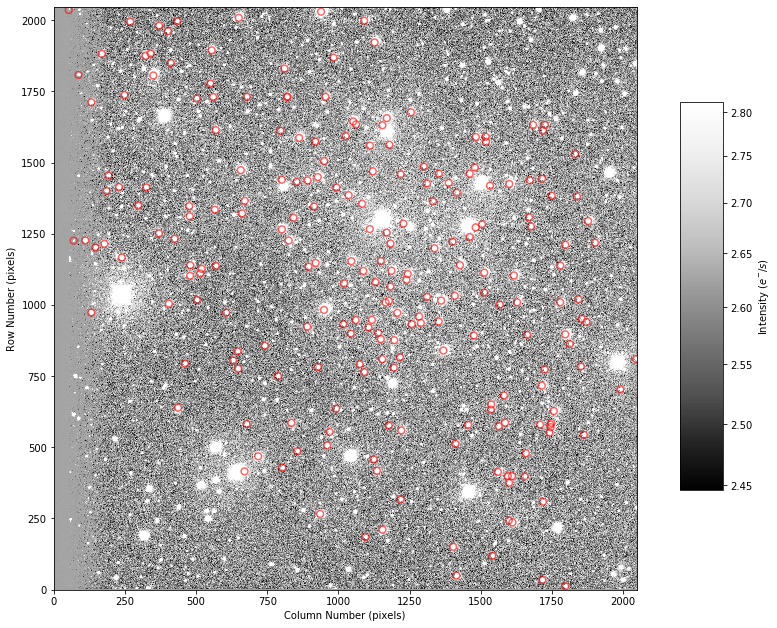

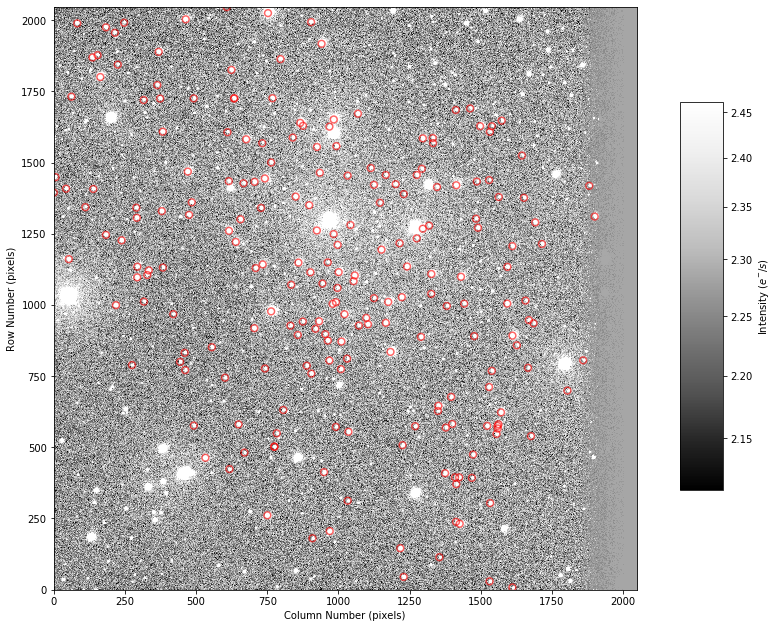

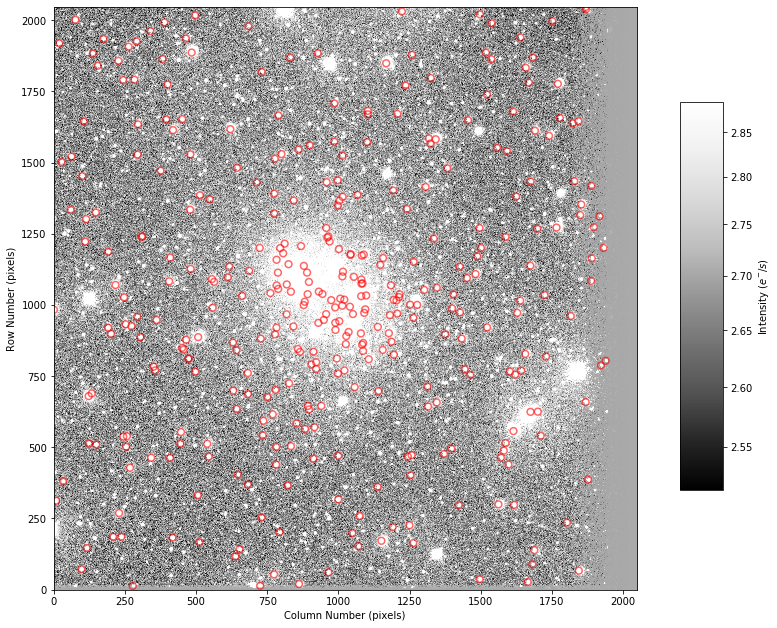

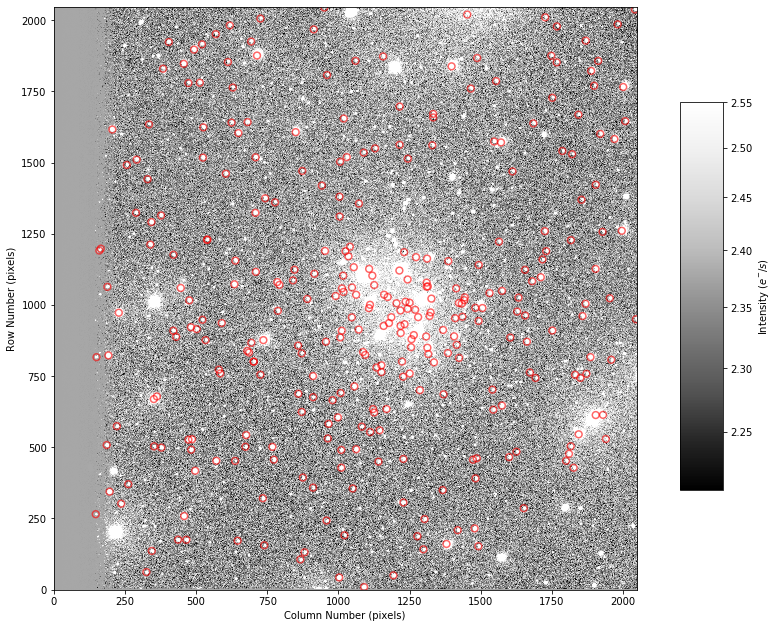

In [41]:
indx_king20_V, indx_ref_king20_V = match_src_ref(refcoord_king20_V, coord_king20_V, srcs_king20_V, img_king20_V)
indx_king20_B, indx_ref_king20_B = match_src_ref(refcoord_king20_B, coord_king20_B, srcs_king20_B, img_king20_B)

indx_ngc7128_V, indx_ref_ngc7128_V = match_src_ref(refcoord_ngc7128_V, coord_ngc7128_V, srcs_ngc7128_V, img_ngc7128_V, radasec = 1.5)
indx_ngc7128_B, indx_ref_ngc7128_B = match_src_ref(refcoord_ngc7128_B, coord_ngc7128_B, srcs_ngc7128_B, img_ngc7128_B, radasec = 1.5)

Now let's calculate the zeropoints for each image.  To compare our objects to those from Pan-STARRS we will need to correct for the effects of airmass.

We start by specifying the atmospheric extinction coefficient for each object.  This says for a typical atmosphere, how much the magnitude changes for an increase in airmass of 1.  We could have measured this using mutliple standard stars but will just assume a cannonical value for now.

In [42]:
def zp_meas(srcs, refcat, indx, indx_ref, hdr):
    kext = {'B': 0.4, 'V': 0.2}
    import numpy.ma as ma

    #this consists of the instrumental magnitude, which is the magnitude, including an airmass correction
    #but without a true zeropoint.  The second term says how the magnitude 
    #m(inst) = -2.5 * log(flux) - (sec z) * k
    instmag = srcs['mag'][indx].data - hdr['AIRMASS'] * kext[hdr['FILTER']]

    #the Pan-STARRS magnitudes for the same objects, as indicated using the indx_ref array
    psmag = refcat[hdr['FILTER']][indx_ref].data

    #calculate the median zeropoint defined as
    #psmag = -2.5 * log(flux) - (sec z) * k + ZP = m(inst) + ZP
    medzp = np.median(psmag - instmag)
    print(hdr['FILTER'],'zeropoint = ', medzp)
    print('Airmass in {} was {}'.format(hdr['FILTER'], hdr['AIRMASS']))
    return medzp

In [43]:
ZPV = zp_meas(srcs_king20_V,refcat_king20_V, indx_king20_V, indx_ref_king20_V,hdr_king20_V)
ZPB = zp_meas(srcs_king20_B,refcat_king20_B, indx_king20_B, indx_ref_king20_B,hdr_king20_B)

nZPV = zp_meas(srcs_ngc7128_V,refcat_ngc7128_V, indx_ngc7128_V, indx_ref_ngc7128_V,hdr_ngc7128_V)
nZPB = zp_meas(srcs_ngc7128_B,refcat_ngc7128_B, indx_ngc7128_B, indx_ref_ngc7128_B,hdr_ngc7128_B)

V zeropoint =  19.605883832093106
Airmass in V was 1.129516
B zeropoint =  19.823599671241322
Airmass in B was 1.131508
V zeropoint =  19.91013628945827
Airmass in V was 1.082708
B zeropoint =  20.566629018879624
Airmass in B was 1.0847


Now match the B and V-band catalogs together for this cluster, apply the zeropoints, and plot a CMD!

In [44]:
def make_CMD(img_B,imgwcs_B,srcs_B,imgwcs_V,srcs_V, hdr_B, hdr_V, ZPB, ZPV, radasec = 1.0):
    import astropy.units as u
    from astropy.coordinates import SkyCoord
    import numpy.ma as ma
    kext = {'B': 0.4, 'V': 0.2}
    rad = radasec * u.arcsec
    
    #This uses the WCS to convert the x and y positions of stars in our image to RA-DEC
    radec_stars_B = imgwcs_B.all_pix2world(srcs_B['xcentroid']+1, srcs_B['ycentroid']+1, 1)
    radec_stars_V = imgwcs_V.all_pix2world(srcs_V['xcentroid']+1, srcs_V['ycentroid']+1, 1)
    #this makes an instance of a SkyCoord class containing the RAs and Decs from the B-band
    coord_B = SkyCoord(ra=radec_stars_B[0]*u.deg, dec=radec_stars_B[1]*u.deg)
    coord_V = SkyCoord(ra=radec_stars_V[0]*u.deg, dec=radec_stars_V[1]*u.deg)

    #this calculates the separations.  The "_" are values that are thrown away
    _, sep2d, _ = coord_B.match_to_catalog_sky(coord_V)

    #plot the histograms
    _ = plt.hist(sep2d.arcsec, bins=100, range=(-0.5, 3))
    plt.xlabel('Sep between B and V sources [arcsec]',fontsize=14)
    plt.ylabel('N',fontsize=14)


    #find the indices of the reference and source list that correspond to matching objects such that
    #the first index in each list corresponds to the first matching object
    indx_B, indx_V, d2d, _ = coord_V.search_around_sky(coord_B, rad)
    nmatch = len(indx_B)
    print('Found {}/{} stars within {}'.format(nmatch, len(srcs_B), rad))
    display_image(img_B, srcs=srcs_B[indx_B], calibrated=True)
    
    #make the B and V-band magnitudes
    magB = srcs_B['mag'][indx_B].data + ZPB - hdr_B['AIRMASS'] * kext[hdr_B['FILTER']]
    magV = srcs_V['mag'][indx_V].data + ZPV - hdr_V['AIRMASS'] * kext[hdr_V['FILTER']]
    #print(magB)
    #print(magV)
    #print(magB-magV)

    #plot the CMD!
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(magB-magV, magV, 'ro',alpha=0.7)
    ax.set_ylim(19,10)
    ax.set_xlabel('B-V',fontsize=18)
    ax.set_ylabel('V',fontsize=18)
    plt.show


In [45]:
def nmake_CMD(img_B,imgwcs_B,srcs_B,imgwcs_V,srcs_V, hdr_B, hdr_V, nZPB, nZPV, radasec = 1.0):
    import astropy.units as u
    from astropy.coordinates import SkyCoord
    import numpy.ma as ma
    kext = {'B': 0.4, 'V': 0.2}
    rad = radasec * u.arcsec
    
    #This uses the WCS to convert the x and y positions of stars in our image to RA-DEC
    radec_stars_B = imgwcs_B.all_pix2world(srcs_B['xcentroid']+1, srcs_B['ycentroid']+1, 1)
    radec_stars_V = imgwcs_V.all_pix2world(srcs_V['xcentroid']+1, srcs_V['ycentroid']+1, 1)
    #this makes an instance of a SkyCoord class containing the RAs and Decs from the B-band
    coord_B = SkyCoord(ra=radec_stars_B[0]*u.deg, dec=radec_stars_B[1]*u.deg)
    coord_V = SkyCoord(ra=radec_stars_V[0]*u.deg, dec=radec_stars_V[1]*u.deg)

    #this calculates the separations.  The "_" are values that are thrown away
    _, sep2d, _ = coord_B.match_to_catalog_sky(coord_V)

    #plot the histograms
    _ = plt.hist(sep2d.arcsec, bins=100, range=(-0.5, 3))
    plt.xlabel('Sep between B and V sources [arcsec]',fontsize=14)
    plt.ylabel('N',fontsize=14)


    #find the indices of the reference and source list that correspond to matching objects such that
    #the first index in each list corresponds to the first matching object
    indx_B, indx_V, d2d, _ = coord_V.search_around_sky(coord_B, rad)
    nmatch = len(indx_B)
    print('Found {}/{} stars within {}'.format(nmatch, len(srcs_B), rad))
    display_image(img_B, srcs=srcs_B[indx_B], calibrated=True)
    
    #make the B and V-band magnitudes
    magB = srcs_B['mag'][indx_B].data + nZPB - hdr_B['AIRMASS'] * kext[hdr_B['FILTER']]
    magV = srcs_V['mag'][indx_V].data + nZPV - hdr_V['AIRMASS'] * kext[hdr_V['FILTER']]
    #print(magB)
    #print(magV)
    #print(magB-magV)

    #plot the CMD!
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(magB-magV, magV, 'ro',alpha=0.7)
    ax.set_ylim(19,10)
    ax.set_xlabel('B-V',fontsize=18)
    ax.set_ylabel('V',fontsize=18)
    plt.show

Found 429/437 stars within 1.0 arcsec


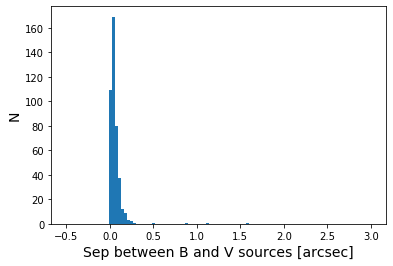

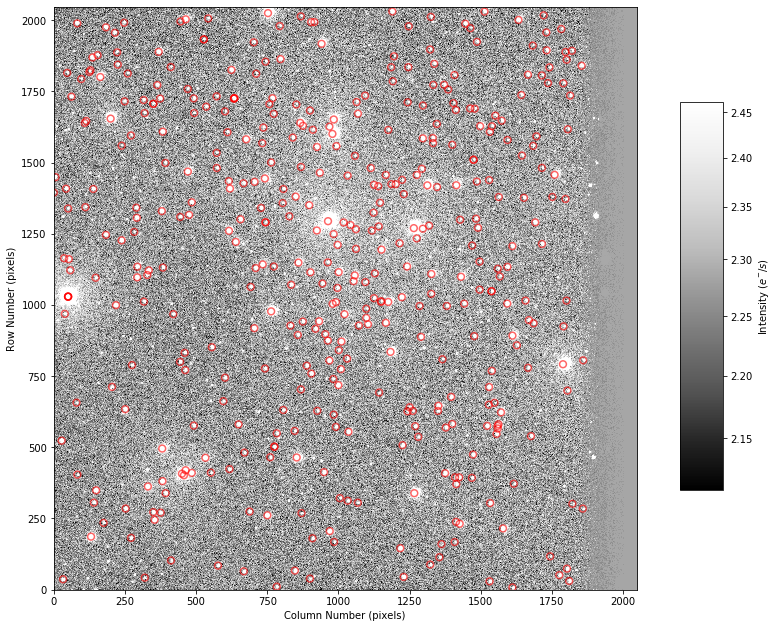

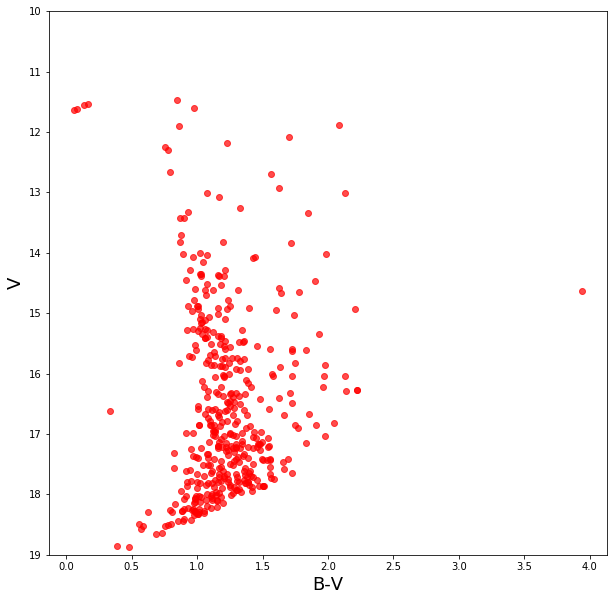

In [46]:
make_CMD(img_king20_B, imgwcs_king20_B, srcs_king20_B,imgwcs_king20_V, srcs_king20_V, hdr_king20_B, hdr_king20_V, ZPB, ZPV, radasec = 1.0)

Found 756/801 stars within 1.5 arcsec


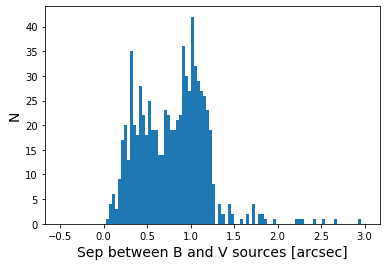

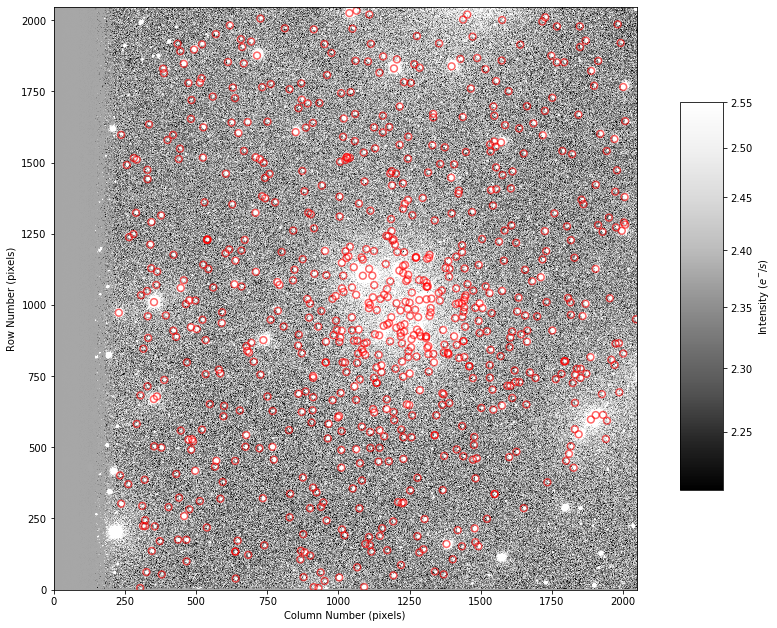

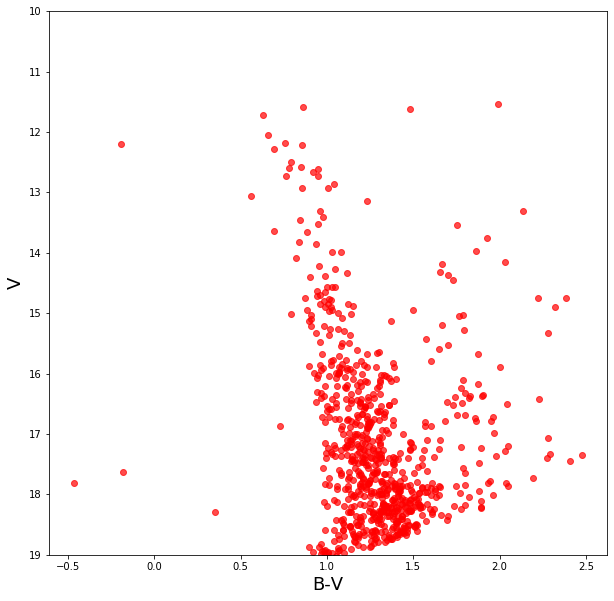

In [47]:
nmake_CMD(img_ngc7128_B, imgwcs_ngc7128_B, srcs_ngc7128_B,imgwcs_ngc7128_V, srcs_ngc7128_V, hdr_ngc7128_B, hdr_ngc7128_V, nZPB, nZPV, radasec = 1.5)

For the King20, our graphs look pretty good. The offset from B to V is centered around zero so the two images are basically identical from a spatial perspective. This tells us that our data is accurate enough to make a decent HR diagram. From the source tracking image, it appears that most of the markers are centered over the stars in the cluster which says that it is tracking the correct objects and not blank areas in the sky. When comparing our HR diagram to the one in webda, they are very similar. We see a cluster of stars around 15 magnitude and 1.0 B-V which matches what webda has. Our HR diagram has an anchor look to it which makes sense because our brightness threshold was set higher than webda's was and we can not build an HR diagram for stars fainter than a center magnitude.